**Корректность проверена на Python 3.7:**
+ pandas 0.23.0
+ numpy 1.14.5
+ scipy 1.1.0
+ statsmodels 0.9.0

# Непараметрические криетрии

  Критерий | Одновыборочный | Двухвыборочный | Двухвыборочный (связанные выборки)  
  ------------- | -------------|
  **Знаков**  | $\times$ | | $\times$ 
  **Ранговый** | $\times$  | $\times$ | $\times$  
  **Перестановочный** | $\times$  | $\times$ | $\times$ 

## Недвижимость в Сиэттле

Имеются данные о продажной стоимости недвижимости в Сиэтле для 50 сделок в 2001 году и 50 в 2002. Изменились ли в среднем цены?

In [2]:
import numpy as np
import pandas as pd
import itertools

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.weightstats import *

In [3]:
import scipy
import statsmodels
print(np.__version__)
print(pd.__version__)
print(scipy.__version__)
print(statsmodels.__version__)

1.16.4
0.24.2
1.4.1
0.10.0


In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных

In [5]:
seattle_data = pd.read_csv('seattle.txt', sep = '\t', header = 0)

In [6]:
seattle_data.shape

(100, 2)

In [7]:
seattle_data.head()

,Price,Year
0,142.0,2002
1,232.0,2002
2,132.5,2002
3,200.0,2002
4,362.0,2002


In [8]:
price2001 = seattle_data[seattle_data['Year']  == 2001].Price
price2002 = seattle_data[seattle_data['Year']  == 2002].Price

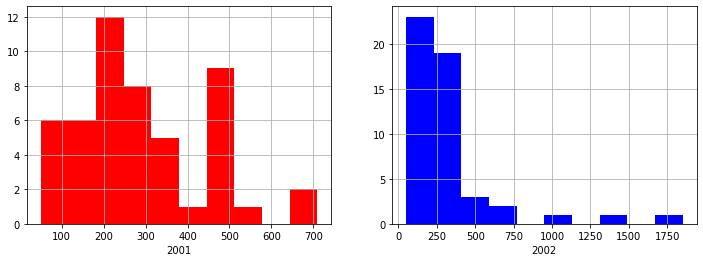

In [9]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(price2001, color = 'r')
pylab.xlabel('2001')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(price2002, color = 'b')
pylab.xlabel('2002')

pylab.show()

## Двухвыборочные критерии для независимых выборок

In [10]:
print('95%% confidence interval for the mean: [%f, %f]' % zconfint(price2001))

95% confidence interval for the mean: [245.193581, 332.659499]


In [11]:
print('95%% confidence interval for the mean: [%f, %f]' % zconfint(price2002))

95% confidence interval for the mean: [241.437946, 417.076334]


### Ранговый критерий Манна-Уитни

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [12]:
stats.mannwhitneyu(price2001, price2002)

MannwhitneyuResult(statistic=1204.5, pvalue=0.3781936337850874)

### Перестановочный критерий

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [13]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [14]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [15]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), list(filter(lambda i: i not in index, range(n)))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

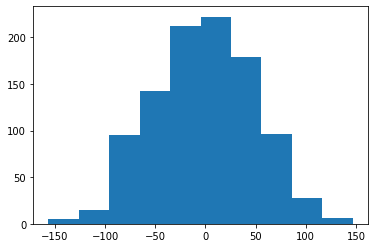

In [16]:
pylab.hist(permutation_zero_dist_ind(price2001, price2002, max_combinations = 1000))
pylab.show()

In [17]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [18]:
print("p-value: %f" % permutation_test(price2001, price2002, max_permutations = 10000))

p-value: 0.448200


In [19]:
print("p-value: %f" % permutation_test(price2001, price2002, max_permutations = 50000))

p-value: 0.441940


В ходе исследования влияния лесозаготовки на биоразнообразие лесов острова Борнео собраны данные о количестве видов деревьев в 12 лесах, где вырубка не ведётся:

22, 22, 15, 13, 19, 19, 18, 20, 21, 13, 13, 15,22,22,15,13,19,19,18,20,21,13,13,15,

и в 9 лесах, где идёт вырубка:

17, 18, 18, 15, 12, 4, 14, 15, 10.17,18,18,15,12,4,14,15,10.

Проверьте гипотезу о равенстве среднего количества видов в двух типах лесов против односторонней альтернативы о снижении биоразнообразия в вырубаемых лесах. Используйте ранговый критерий. Чему равен достигаемый уровень значимости? Округлите до четырёх знаков после десятичной точки.

In [20]:
forest_1 = np.array([22, 22, 15, 13, 19, 19, 18, 20, 21, 13, 13, 15])
forest_2 = np.array([17, 18, 18, 15, 12, 4, 14, 15, 10])

In [23]:
round(stats.mannwhitneyu(forest_1, forest_2).pvalue,4)

0.029

28 января 1986 года космический шаттл "Челленджер" взорвался при взлёте. Семь астронавтов, находившихся на борту, погибли. В ходе расследования причин катастрофы основной версией была неполадка с резиновыми уплотнительными кольцами в соединении с ракетными ускорителями. Для 23 предшествовавших катастрофе полётов "Челленджера" известны температура воздуха и появление повреждений хотя бы у одного из уплотнительных колец.

challenger.txt
С помощью бутстрепа постройте 95% доверительный интервал для разности средних температур воздуха при запусках, когда уплотнительные кольца повреждались, и запусках, когда повреждений не было. Чему равна его ближайшая к нулю граница? Округлите до четырёх знаков после запятой.

Чтобы получить в точности такой же доверительный интервал, как у нас:

установите random seed = 0 перед первым вызовом функции get_bootstrap_samples, один раз
сделайте по 1000 псевдовыборок из каждой выборки.

In [26]:
data = pd.read_csv('challenger.txt', delimiter='\\t')

/Users/dmitrijbordugov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [109]:
incident = data.Temperature[data.Incident==1]
success = data.Temperature[data.Incident==0]
print('Mean = ', success.mean()-incident.mean())

Mean =  4.666964285714283


In [94]:
np.random.seed(0)
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

success_samples = get_bootstrap_samples(success, 1000)
incident_samples = get_bootstrap_samples(incident, 1000)

In [95]:
success_means = np.mean(success_samples, axis=1)
incident_means = np.mean(incident_samples, axis=1)

In [111]:
means = incident_means - success_means

In [113]:
round(zconfint(means)[1], 4)

-4.5263

In [106]:
np.random.seed(0)
permutation_test(success, incident, max_permutations = 10000)

0.007